In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
%matplotlib inline

In [2]:
# Physical system constants/parameters
g = 9.8 # gravity in metres per second per second
mass = 0.1
k_s = 2.5 # spring constant
k_d = 0.1 # damping coefficient

# Initial conditions
t0 = 0.0
x0 = [-1., 0.]

# Control system parameters
f_smc = 10. # Sliding mode controller force limit (in Newtons)
c = [20., 1.] # Sliding mode coefficients
sgn_sigma = 0 # SMC output state (global variable for DT simulation)

In [3]:
def add_disturbance(t, x_dot):
  v = x_dot[0]
  a = x_dot[1] + 5.*np.sin(10*t)
  return [v,a]

def add_smc(t, x_dot):
  a = x_dot[1] - (f_smc/mass)*sgn_sigma
  return [x_dot[0], a]

In [4]:
def f_raw(t, x, m, k1, k2):
  # Manual implementation of state transition matrix
  v = x[1]
  a = -((k1*x[0])/m) + -((k2*x[1])/m)
  
  # Add acceleration due to gravity
  a += g

  # return the state derivative
  return [v, a]

In [5]:
def f_dist(t, x, m, k1, k2):
  x_dot = f_raw(t, x, m, k1, k2)
  x_dot = add_disturbance(t, x_dot)
  return x_dot

def f_smc_raw(t, x, m, k1, k2):    
  x_dot = f_raw(t, x, m, k1, k2)
  x_dot = add_smc(t,x_dot)
  return x_dot

def f_smc_dist(t, x, m, k1, k2):    
  x_dot = f_raw(t, x, m, k1, k2)  
  x_dot = add_disturbance(t,x_dot)
  x_dot = add_smc(t,x_dot)
  return x_dot

In [6]:
# Create an `ode` instance to solve the system of differential
# equations defined by `fun`
solver_raw = ode(f_raw)
solver_dist = ode(f_dist)
solver_smc_dist = ode(f_smc_dist)

# Collect all system descriptions in order to treat them identically
solvers = [solver_raw, solver_dist, solver_smc_dist]

# Treat all systems to the same simulation set up
for slvr in solvers:
  # ODE solver method
  slvr.set_integrator('dopri5')

  # Set ODE function parameters for use by the solver
  slvr.set_f_params(mass,k_s,k_d)

  # Set the initial value z(0) = z0.
  slvr.set_initial_value(x0, t0)

In [7]:
# Create the array `t` of time values at which to compute
# the solution, and create an array to hold the solution.
# Put the initial value in the solution array.
tend = 10.
N = 10000
t = np.linspace(t0, tend, N)
N_sol = len(solvers)
sol = np.empty((N, 2, N_sol))

# Log the SMC control output
sigma = np.empty((N, 1))

In [8]:
## Discrete time SMC requires manipulating global control parameters at 
## pre-determined points in time.
# Repeatedly call the `integrate` method to advance the
# solution to time t[k], and save the solution in sol[k].

for i,slvr in enumerate(solvers):
  sol[0,:,i] = x0
  k = 1
  while slvr.successful() and slvr.t < tend:
      # Execute the numerical integration
      slvr.integrate(t[k])
      # Calculate (and log) the sliding mode "error?"
      sigma[k] = c[0]*slvr.y[0] + c[1]*slvr.y[1]
      # Log the output of the solver
      sol[k,:,i] = slvr.y
  
      # Apply the limit cycle
      if sigma[k] > 0.:
          sgn_sigma = 1.
      else:
          sgn_sigma = -1.
      # Advance the index for data logging
      k += 1

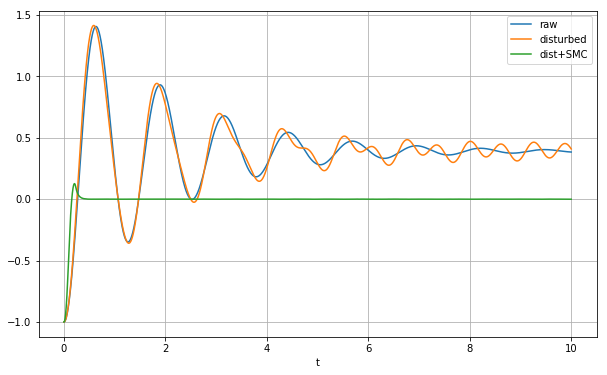

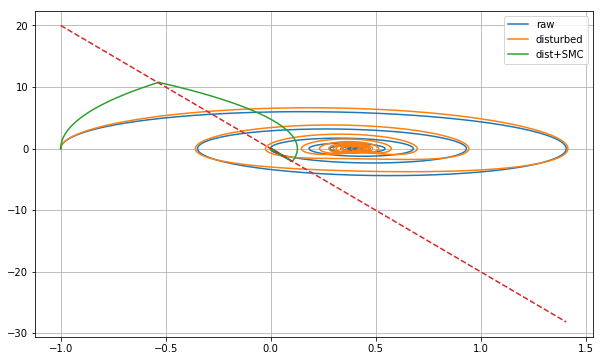

In [10]:
# Plot the solution...
fig0 = plt.figure(0, figsize=(10,6))
plt.plot(t, sol[:,0], label='x')
#plt.plot(t, sol[:,1], label='xd')
#plt.plot(t, sigma, label='sig')
plt.xlabel('t')
plt.grid(True)
leg = ['raw','disturbed','dist+SMC']
plt.legend(leg)

smc_range_x0 = np.array([np.amin(sol[:,0,0]),np.amax(sol[:,0,0])])
smc_range_x1 = -c[0]/c[1]*smc_range_x0
fig0 = plt.figure(1, figsize=(10,6))
plt.plot(sol[:,0], sol[:,1], label='xd vs x')
plt.plot(smc_range_x0,smc_range_x1,'--')
plt.grid(True)
plt.legend(leg)